**CREDIT CARD FRAUD DETECTION**

Data loading

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set display options
pd.set_option('display.max_columns', None)

# Load the dataset
column_names = ['transaction_date', 'transaction_amount', 'carholder_name', 'card_number',
                 'merchant_name', 'merchant_category_code', 'transaction_location', 'transaction_currency',
                 'card_type', 'card_expiration_date', 'CVV_code', 'transaction_code', 'transaction_ID',
                 'fraud_label', 'previous_transactions', 'transaction_source', 'IP_address',
                 'device_information', 'user_information', 'transaction_notes']

df = pd.read_csv("credit_card_fraud.csv", names=column_names, header=0)

# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
print("Information about the dataset:")
print(df.info())


Shape of the dataset: (8000, 20)
Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_date        8000 non-null   object 
 1   transaction_amount      8000 non-null   float64
 2   carholder_name          8000 non-null   object 
 3   card_number             8000 non-null   object 
 4   merchant_name           8000 non-null   object 
 5   merchant_category_code  8000 non-null   int64  
 6   transaction_location    8000 non-null   object 
 7   transaction_currency    8000 non-null   object 
 8   card_type               8000 non-null   object 
 9   card_expiration_date    8000 non-null   object 
 10  CVV_code                8000 non-null   object 
 11  transaction_code        8000 non-null   int64  
 12  transaction_ID          8000 non-null   object 
 13  fraud_label             8000 

Handling missing values

In [ ]:
# Display the count and percentage of null values in each column
nulls_summary = pd.DataFrame({'nulls_count': df.isnull().sum(), 'nulls_%': df.isnull().mean() * 100})
print(nulls_summary)

                        nulls_count  nulls_%
transaction_date                  0    0.000
transaction_amount                0    0.000
carholder_name                    0    0.000
card_number                       0    0.000
merchant_name                     0    0.000
merchant_category_code            0    0.000
transaction_location              0    0.000
transaction_currency              0    0.000
card_type                         0    0.000
card_expiration_date              0    0.000
CVV_code                          0    0.000
transaction_code                  0    0.000
transaction_ID                    0    0.000
fraud_label                       0    0.000
previous_transactions             0    0.000
transaction_source                0    0.000
IP_address                        0    0.000
device_information                0    0.000
user_information               4010   50.125
transaction_notes                 0    0.000


Visualising data

In [ ]:
# Visualize Fraud Flags distribution using a pie chart
px.pie(df, names='fraud_label', title='Fraud Flags distribution', hole=0.6)

Data pre processing

In [ ]:
# Convert date columns to datetime format
df.transaction_date = pd.to_datetime(df.transaction_date, format="%Y-%m-%d %H:%M:%S")
df.card_expiration_date = pd.to_datetime(df.card_expiration_date, format="%m/%y")

In [ ]:
# Analyze and visualize low cardinality features
cardinality = df.drop("fraud_label", axis=1).nunique().sort_values(ascending=False)
low_cardinality = cardinality[cardinality < 500].index.to_list()[1:]

fig = make_subplots(rows=len(low_cardinality),
                    cols=1,
                    subplot_titles=low_cardinality,
                    row_heights=[10] * len(low_cardinality))

for i, feature in enumerate(low_cardinality):
    plot = px.histogram(df, x=feature, color="fraud_label")
    fig.add_trace(plot.data[0], row=i + 1, col=1)
    fig.add_trace(plot.data[1], row=i + 1, col=1)

fig.update_layout(width=1000,
                  height=2000,
                  title_text="Low cardinality features distribution",
                  showlegend=False
                 )


In [ ]:

# Visualize transaction date distribution
plot = px.histogram(df, x="transaction_date", title="Transactions date distribution")
plot.update_traces(marker=dict(line=dict(color='white', width=1)))

In [ ]:

# Extract features from transaction date
df['transaction_date_year'] = df.transaction_date.dt.year
df['transaction_date_month'] = df.transaction_date.dt.month
df['transaction_date_day'] = df.transaction_date.dt.day
df['transaction_date_day_of_week'] = df.transaction_date.dt.day_of_week
df['transaction_date_hour'] = df.transaction_date.dt.hour

<Axes: title={'center': 'Merchant Category Code'}, xlabel='merchant_category_code', ylabel='Count'>

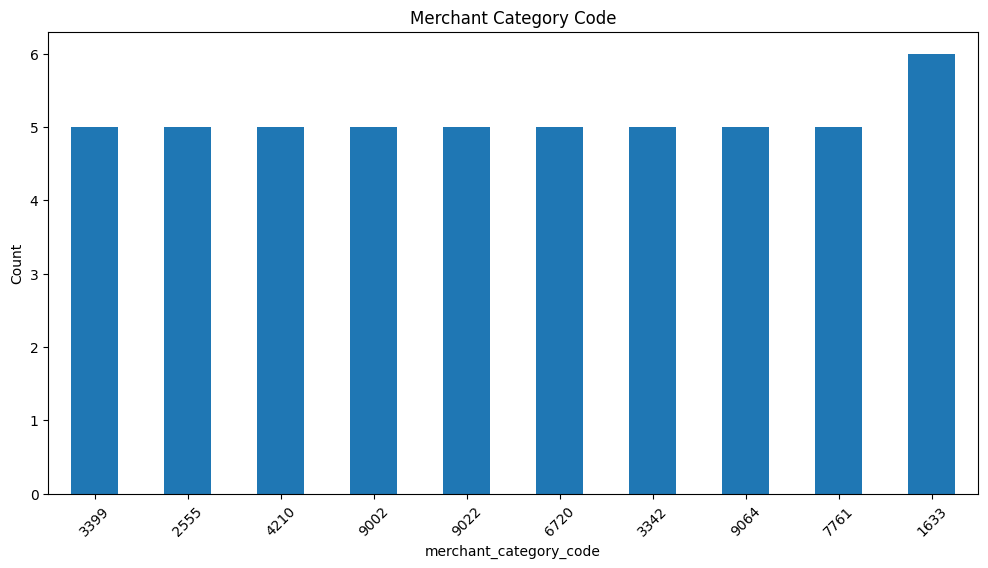

In [ ]:
# Visualize the top 10 merchant categories by count
df.groupby("merchant_category_code").size().sort_values().tail(10).plot.bar(figsize=(12,6), rot=45, ylabel="Count", title="Merchant Category Code")

Text(0.5, 1.0, 'Not Fraud')

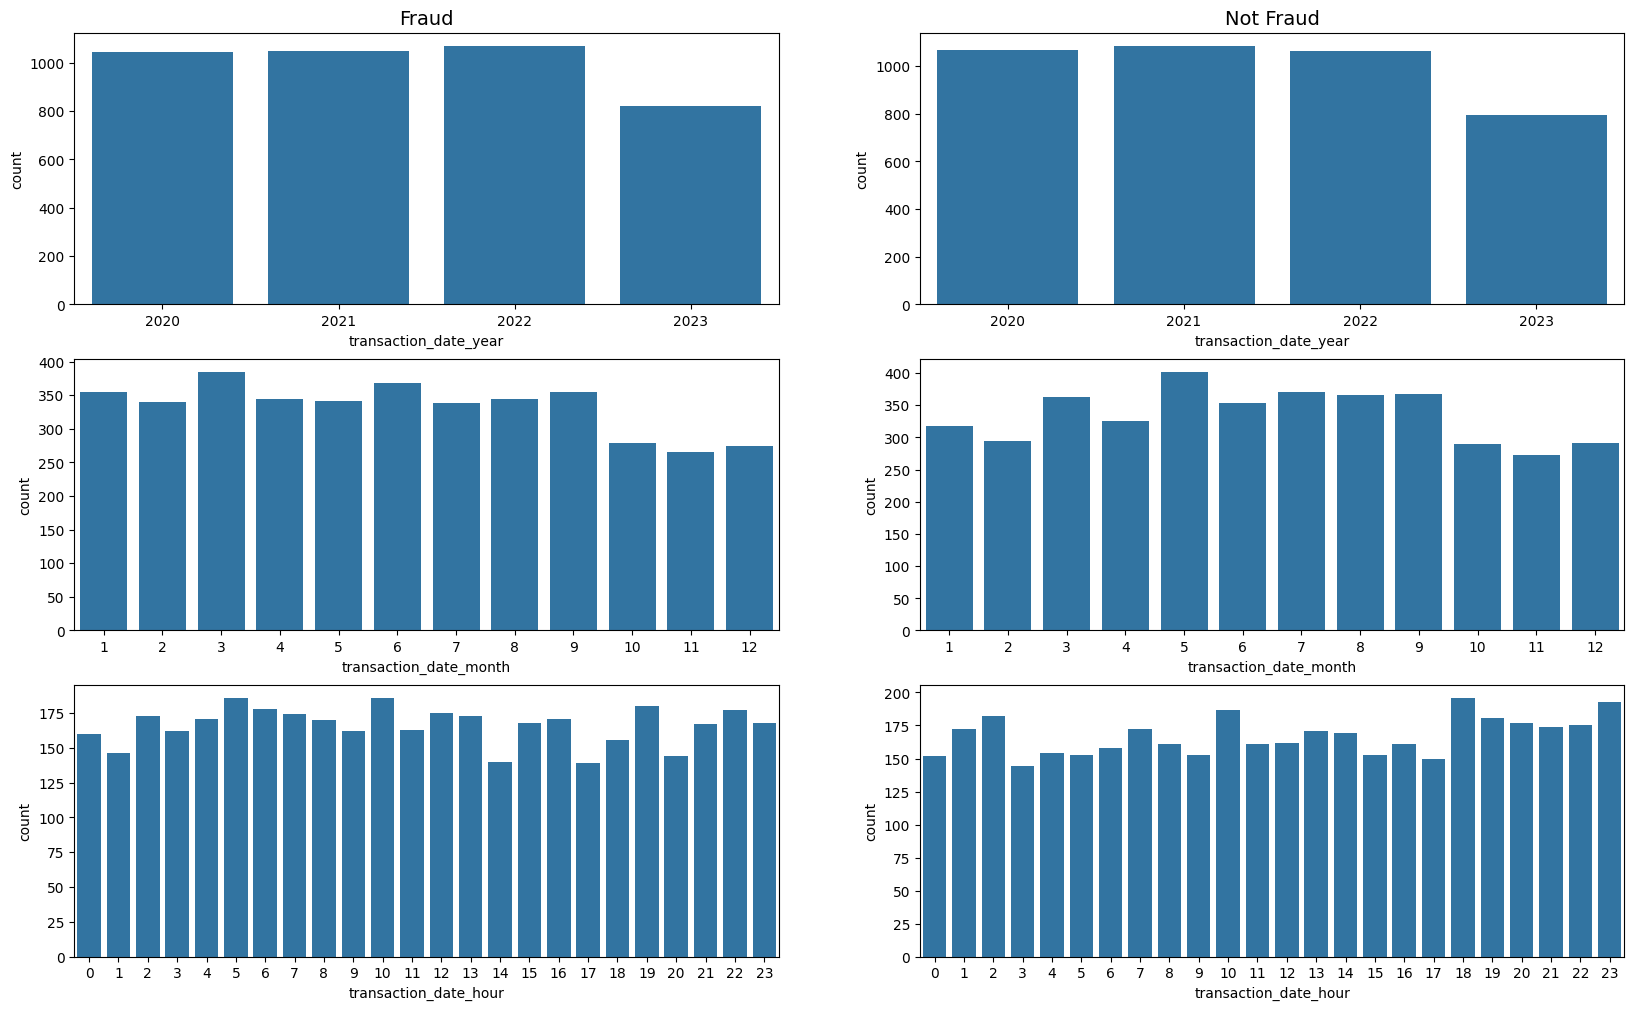

In [ ]:
# Visualize fraud and not fraud counts for different time periods
fig, axes = plt.subplots(3, 2, figsize=(20, 12))

for i, time in enumerate(['year', 'month', 'hour']):
    sns.countplot(data=df[df.fraud_label == 1], x="transaction_date_" + time, ax=axes[i,0])
    sns.countplot(data=df[df.fraud_label == 0], x="transaction_date_" + time, ax=axes[i,1])
axes[0,0].set_title("Fraud", fontsize=14)
axes[0,1].set_title("Not Fraud", fontsize=14)


In [ ]:
# Visualize currency distribution using a pie chart
px.pie(df, names="transaction_currency", title="Currency Distribution")

<Axes: xlabel='carholder_name'>

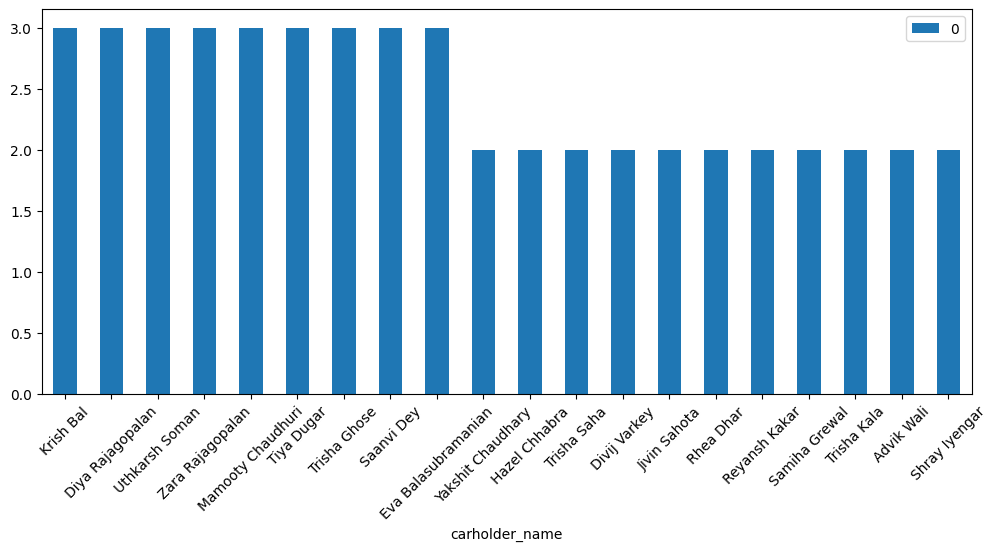

In [ ]:
# Visualize top 20 carholder suspects based on transaction count
carholder_suspects = df.groupby(["carholder_name"]).size().sort_values(ascending=False).head(20).reset_index()
carholder_suspects.plot.bar(x="carholder_name", figsize=(12,5), rot=45)


 ======================================== PLOT ========================================


<Figure size 1500x1000 with 0 Axes>

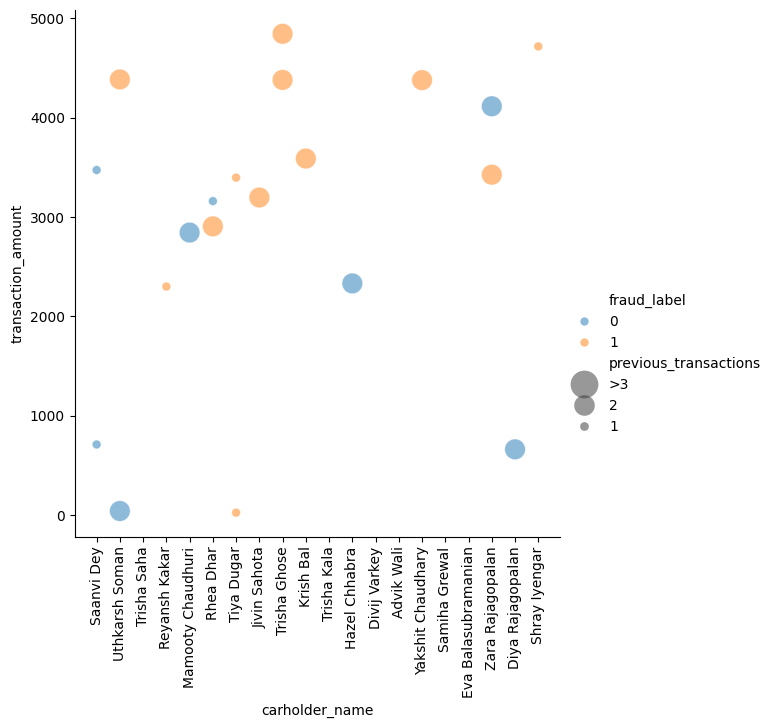

In [ ]:
# Visualize relationship between carholder, transaction amount, and fraud label
df.previous_transactions = pd.Categorical(df.previous_transactions, categories=["1", "2", ">3"], ordered=True)
plt.figure(figsize=(15,10))
sns.relplot(x="carholder_name", y="transaction_amount", hue="fraud_label", size="previous_transactions",
            sizes=(40, 400), size_order=[">3", "2", "1"], alpha=.5,
            height=6, data=df[df.carholder_name.isin(carholder_suspects.carholder_name)])
plt.xticks(rotation=90)
print('\n', "=" * 40, "PLOT", "=" * 40)

Modeling data

In [ ]:
# Reload the dataset for the modeling part
df = pd.read_csv("credit_card_fraud.csv", names=column_names, header=0)

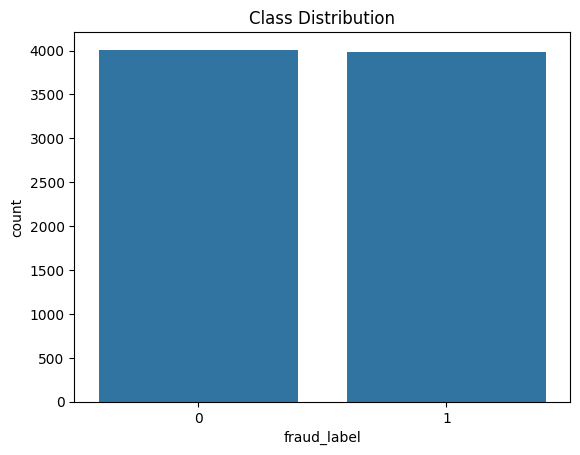

In [ ]:

# Visualize class distribution
sns.countplot(x='fraud_label', data=df)
plt.title('Class Distribution')
plt.show()


In [ ]:
# Preprocess the data for the model
df_numeric = df.drop(['transaction_date', 'carholder_name', 'card_number', 'merchant_name',
                      'transaction_location', 'transaction_currency', 'card_type', 'card_expiration_date',
                      'CVV_code', 'transaction_code', 'transaction_ID', 'previous_transactions',
                      'transaction_source', 'IP_address', 'device_information', 'user_information', 'transaction_notes'],
                     axis=1)

df_numeric = df_numeric.fillna(0)
X = df_numeric.drop('fraud_label', axis=1).values
y = df_numeric['fraud_label'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)


In [ ]:
# Instantiate the improved model
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1


In [ ]:
class ImprovedNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x


In [ ]:
# Instantiate the improved model
improved_model = ImprovedNN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)


In [ ]:
# Use a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr=1e-6)

In [ ]:
# Training loop with learning rate scheduler
num_epochs = 100

for epoch in range(num_epochs):
    # Forward pass
    outputs = improved_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Learning rate scheduler step
    scheduler.step(loss)

    # Print the loss at every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [10/100], Loss: 0.704272985458374
Epoch [20/100], Loss: 0.697648823261261
Epoch [30/100], Loss: 0.6942629814147949
Epoch [40/100], Loss: 0.693112313747406
Epoch [50/100], Loss: 0.6928779482841492
Epoch [60/100], Loss: 0.6928198337554932
Epoch [70/100], Loss: 0.6928148865699768
Epoch [80/100], Loss: 0.6928147077560425
Epoch [90/100], Loss: 0.6928145885467529
Epoch [100/100], Loss: 0.6928144693374634


**DOCUMENTATION**





**Importing Libraries**

Import necessary libraries such as pandas, numpy, seaborn, matplotlib, and PyTorch to perform data manipulation, visualization, machine learning, and deep learning.

***Data Loading**

Data loading is done using pandas. Download the Credit Card Fraud Dataset from Kaggle. Load the credit card fraud dataset CSV file into a pandas DataFrame. The dataset contains 20 columns. The columns are 'transaction_date', 'transaction_amount', 'carholder_name', 'card_number',
                 'merchant_name', 'merchant_category_code', 'transaction_location', 'transaction_currency',
                 'card_type', 'card_expiration_date', 'CVV_code', 'transaction_code', 'transaction_ID',
                 'fraud_label', 'previous_transactions', 'transaction_source', 'IP_address',
                 'device_information', 'user_information', 'transaction_notes'

**Display basic information about the dataset**

Print the shape of the dataset and general information about its columns, such as data types and non-null counts using 'df.shape' and 'df.info()'.

**Handling missing values**

Create a DataFrame 'nulls_summary' containing the count and percentage of null values in each column and print it.

**Visualising data**

To visualize Fraud Flags distribution using a pie chart use Plotly Express.

**Convert date columns to datetime format**

Convert the 'transaction_date' and 'card_expiration_date' columns to datetime format using 'pd.to_datetime()'.

**Analyzing and Visualizing Low Cardinality Features**

Analyze features with low cardinality (less than 500 unique values) by creating histograms for each feature with fraud label as a different color using Plotly Express. These histograms are plotted in subplots using 'make_subplots()'.

**Visualize Transaction Date Distribution**

Create a histogram to visualize the distribution of transactions over time using Plotly Express.

**Extract features from transaction date**

Extract various features from the 'transaction_date' column such as year, month, day, day of the week, and hour, and add them as new columns to the DataFrame.

**Visualize the top 10 merchant categories by count**

Plot a bar chart showing the top 10 merchant categories by count.

**Visualize Fraud and Not Fraud Counts for Different Time Periods**

Create subplots using seaborn to visualize the counts of fraud and not fraud transactions for different time periods (year, month, and hour).

**Visualize currency distribution using a pie chart**

Generate a pie chart using Plotly Express to visualize the distribution of transaction currencies in the dataset.

**Visualize top 20 carholder suspects based on transaction count**

Create a bar plot to display the top 20 carholder suspects based on transaction count.

**Visualize relationship between carholder, transaction amount, and fraud label**

A scatter plot is generated to show the relationship between the carholder's name, transaction amount, and fraud label. The size of the points indicates the number of previous transactions, and the colors represent fraud labels.

**Modeling data**

*   Reload the dataset for the modeling part.
*   Visualize class distribution - The class distribution of fraud labels is visualized using a count plot.
*   Preprocess the data for the model - Data preprocessing is performed to prepare the dataset for model training. Numeric features are selected and filled with zeros if there are any missing values.
*   Standardize the features - The features are standardized using 'StandardScaler'.
*   Split the data into training and testing sets
*   Convert to PyTorch tensors





***Model Definition**

**Designing Hidden Layers:**

Hidden layers in neural networks are layers between the input and output layers where computations are performed.
Define the neural network with one hidden layer using PyTorch's **'nn.Linear()'** module.

**Activation Functions:**

Activation functions introduce non-linearity to the neural network, enabling it to learn complex patterns in the data.
In the code, **ReLU (nn.ReLU())** is used as the activation function for the hidden layer, and **Sigmoid (nn.Sigmoid())** is used for the output layer.

**Stochastic Gradient Descent (SGD):**

SGD is an optimization algorithm used to minimize the loss function by updating the model parameters in the direction of the steepest descent.
In the code, Adam optimizer **(optim.Adam())** is used, which is an extension of SGD and performs adaptive learning rates.

**Forward Propagation from Scratch:**

Forward propagation involves passing the input data through the neural network layers to obtain the predicted output.
In the code, forward propagation is implemented within the **'forward()'** method of the '**ImprovedNN**' class.
The input data is passed through the hidden layer **(self.layer1)** followed by the **ReLU activation function** and then through the output layer **(self.layer2)** followed by the **Sigmoid activation function**.

**Model Training**

*   The training loop iterates over a specified number of epochs.
*   It performs **forward pass**, calculates the loss using binary cross-entropy loss, performs backward pass, and updates the model parameters using Adam optimizer.
*   Learning rate scheduler is applied to dynamically adjust the learning rate during training.
*   Loss is printed every 10 epochs for monitoring training progress.